# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 1. Метрики и меры схожести.**

Смена рабочей директории.

In [1]:
#import os
#os.chdir('/content/drive/MyDrive/TimeSeriesCourse/practice/01 Basics')

Использование команд, которые автоматически перезагружают все импортированные модули при их изменении.

In [2]:
#%load_ext autoreload
#%autoreload 2

## **Часть 1.** Евклидова метрика и DTW мера. Матрица расстояний. Иерархическая кластеризация.

Импорт библиотек и модулей.

In [3]:
#!pip3 install plotly
import numpy as np
import pandas as pd

from modules.metrics import *
from modules.utils import *
from modules.plots import *

### **Задача 1.**
Вам необходимо самостоятельно реализовать функцию `ED_distance()` в модуле *metrics.py* для нахождения евклидовой метрики между временными рядами, имеющими одинаковую длину, и проверить ее реализацию с помощью функции `euclidean_distance()` из библиотеки *sktime*. В качестве входных данных используйте два синтетических временных ряда некоторой заданной вами длины, сгенерированных моделью случайных блужданий (Random Walk). Модель случайных блужданий реализуйте самостоятельно или используйте готовые реализации.

*Евклидова метрика* между временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
    \text{ED}(T_1, T_2) = \sqrt{\sum_{i=1}^{n} ({t_{1}}_i-{t_{2}}_i)^2}.
\end{equation}

In [4]:
#!pip3 install numpy
#!pip3 install plotly

In [5]:
#!pip3 install pip install numba==0.53.0
#!pip install sktime

In [6]:
#!pip3 install librosa

In [7]:
from sktime.distances import euclidean_distance
import random
import numpy as np

def test_ed_distance(ts1, ts2):

    sktime_ed_dist = round(euclidean_distance(ts1, ts2), 5)
    desired_ed_dist = round(ED_distance(ts1, ts2), 5)

    np.testing.assert_equal(sktime_ed_dist, desired_ed_dist, 'ED distances are not equal')
    


In [8]:
# INSERT YOUR CODE
#ts1 = np.array([2, 5, 0])
ts1 = np.array([2, 5, 0])
ts2 = np.array([4, 6, 7])
test_ed_distance(ts1, ts2)

### **Задача 2.**

Вам необходимо самостоятельно реализовать функцию `DTW_distance()` в модуле *metrics.py* для нахождения DTW меры между временными рядами, имеющими одинаковую длину, и проверить ее реализацию с помощью функции `dtw_distance()` из библиотеки *sktime*. Сгенерируйте два временных ряда некоторой заданной вами длины с помощью модели случайных блужданий (Random Walk) или используйте ряды из предыдущей задачи.

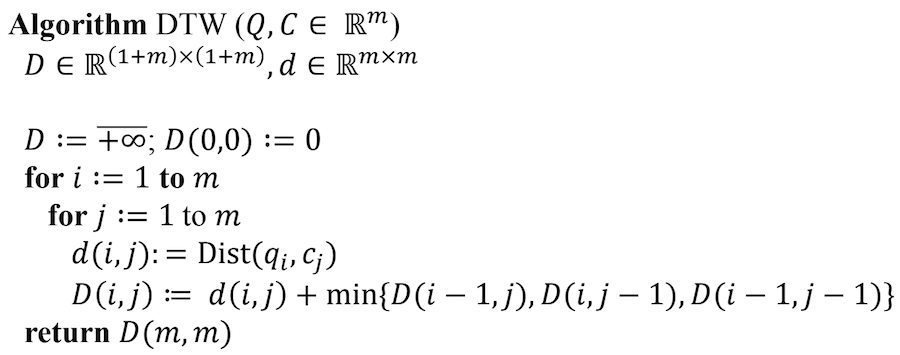

In [9]:
import random
from sktime.distances import dtw_distance

def test_dtw_distance(ts1, ts2):

    sktime_dtw_dist = dtw_distance(ts1, ts2)
    desired_dtw_dist = DTW_distance(ts1, ts2)

    np.testing.assert_equal(sktime_dtw_dist, desired_dtw_dist, 'DTW distances are not equal')

In [10]:
# INSERT YOUR CODE
#ts1 = np.array([2, 5, 0])
ts1 = np.array([2, 5, 0])
ts2 = np.array([4, 6, 7])
test_dtw_distance(ts1, ts2)

### **Задача 3.**
Реализуйте функцию нахождения матрицы расстояния между временными рядами. Для вычисления расстояний между рядами используйте реализованные вами функции `ED_distance()` и `DTW_distance()` из модуля *metrics.py*.

Поскольку евклидова метрика и DTW мера удовлетворяют аксиоме симметричности (т.е. $dist(A,B)=dist(B,A)$), то матрица расстояний будет квадратной и симметричной относительно главной диагонали. Для ускорения вычислений достаточно найти ее верхний треугольник, а нижний треугольник матрицы заполнить значениями верхнего треугольника следующим образом: $dist\_matrix(j,i) = dist\_matrix(i,j)$, где $i < j$.

In [11]:
def calculate_distance_matrix(data, metric='euclidean', normalize=False):

    N = data.shape[0] # number of time series

    # Initialize the distance matrix
    distance_matrix = np.zeros(shape=(N, N))

    # INSERT YOUR CODE
    for i in range(N):
        for j in range(N):
            if(i>j):
                if(metric=='euclidean'):
                    if(normalize):
                        distance_matrix[i,j]=norm_ED_distance(data[i],data[j])
                    else:
                        distance_matrix[i,j]=ED_distance(data[i],data[j])
                elif(metric=='DTW'):
                    if(normalize):
                        distance_matrix[i,j]=DTW_distance(z_normalize(data[i]),z_normalize(data[j]))
                    else: 
                        distance_matrix[i,j]=DTW_distance(data[i],data[j])
            if(i<j):
                distance_matrix[j,i]=distance_matrix[i,j] 
    return distance_matrix

calculate_distance_matrix(np.array([ts1,ts2]))

array([[0.        , 0.        ],
       [7.34846923, 0.        ]])

### **Задача 4.**
Далее рассмотрим задачу иерархической кластеризации временных рядов, где будет использоваться вычисленная матрица расстояний.

Для этого сначала загрузите набор временных рядов CBF из файла CBF_TRAIN.txt. Каждая строка данного файла содержит целевую переменную (класс: 0, 1 или 2), которая записана в первом столбце, и временной ряд -- в остальных столбцах. Набор CBF является синтетическим и включает в себя 30 временных рядов,  каждый из которых принадлежит к одному из трех классов.

In [12]:
def load_ts(file_name):

    ts = pd.read_csv(file_name, header=None, delim_whitespace=True)

    return ts

In [13]:
url = './datasets/part1/CBF_TRAIN.txt'

data = load_ts(url)

ts_set = data.iloc[:, 1:].to_numpy()
labels = data.iloc[:, 0].squeeze().to_numpy()

Выполните визуализацию экземпляра каждого класса. Для этого используйте функцию `plot_ts_set()` из модуля *plots.py*.

In [14]:
# INSERT YOUR CODE
plot_ts_set(ts_set)

Далее вам необходимо самостоятельно реализовать класс для выполнения иерархической кластеризации временных рядов.

Перед тем как приступить к его реализации, изучите скелет класса `TimeSeriesHierarchicalClustering`, который представлен в модуле *clustering.py*. Реализуйте метод `fit()`, выполняющий кластеризацию данных на основе предвычисленной матрицы расстояний, которая передается в данный метод. Поскольку реализовать иерархическую кластеризацию довольно сложно, используйте готовую реализацию AgglomerativeClustering из *sklearn*.   

Протестируйте свою реализацию иерархической кластеризации на наборе данных CBF для двух метрик: евлидовой метрики и DTW меры.
Для этого сначала найдите матрицы расстояний между временными рядами и передайте их в метод `fit()` для кластеризации.
Далее выполните визуализацию результатов в виде дендрограмм с помощью метода `plot_dendrogram()`, передав исходный набор временных рядов и их метки.

In [15]:
#!pip3 install matplotlib

In [16]:
from modules.clustering import *

In [17]:
# INSERT YOUR CODE
model1=TimeSeriesHierarchicalClustering()
model2=TimeSeriesHierarchicalClustering()
#model1.fit(calculate_distance_matrix(np.array([ts1,ts2])))


In [18]:
model2.fit(calculate_distance_matrix(ts_set,'DTW'))

In [19]:
import pandas as pd

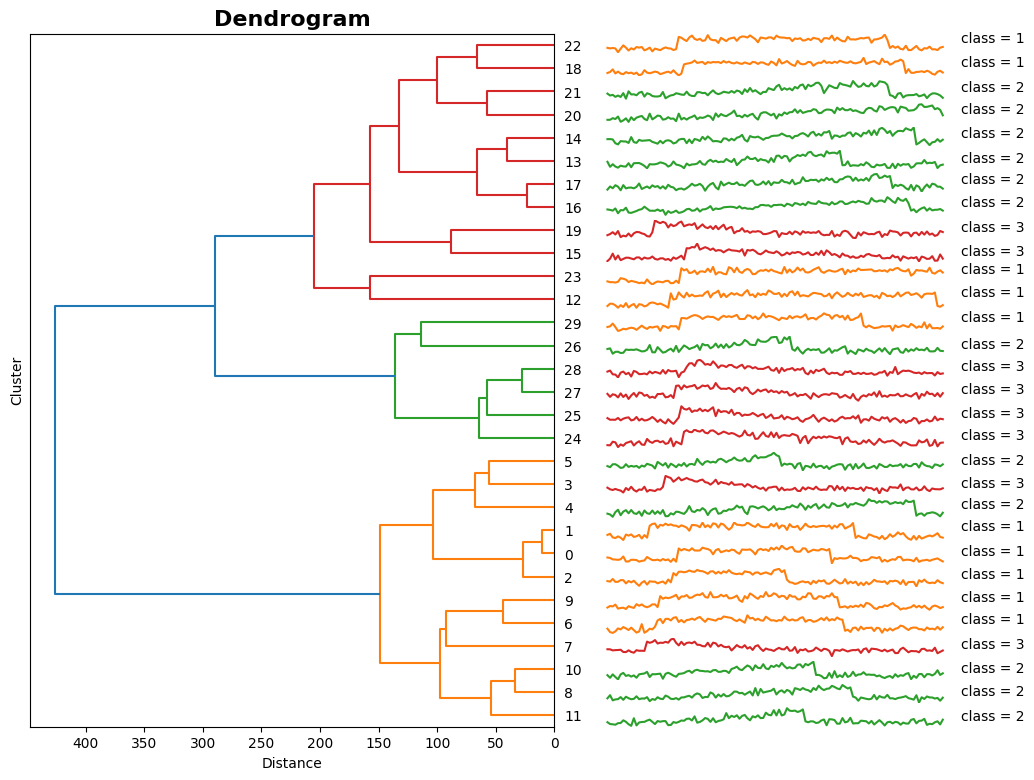

In [20]:
model2.plot_dendrogram(ts_set,labels)
#model2.plot_dendrogram()

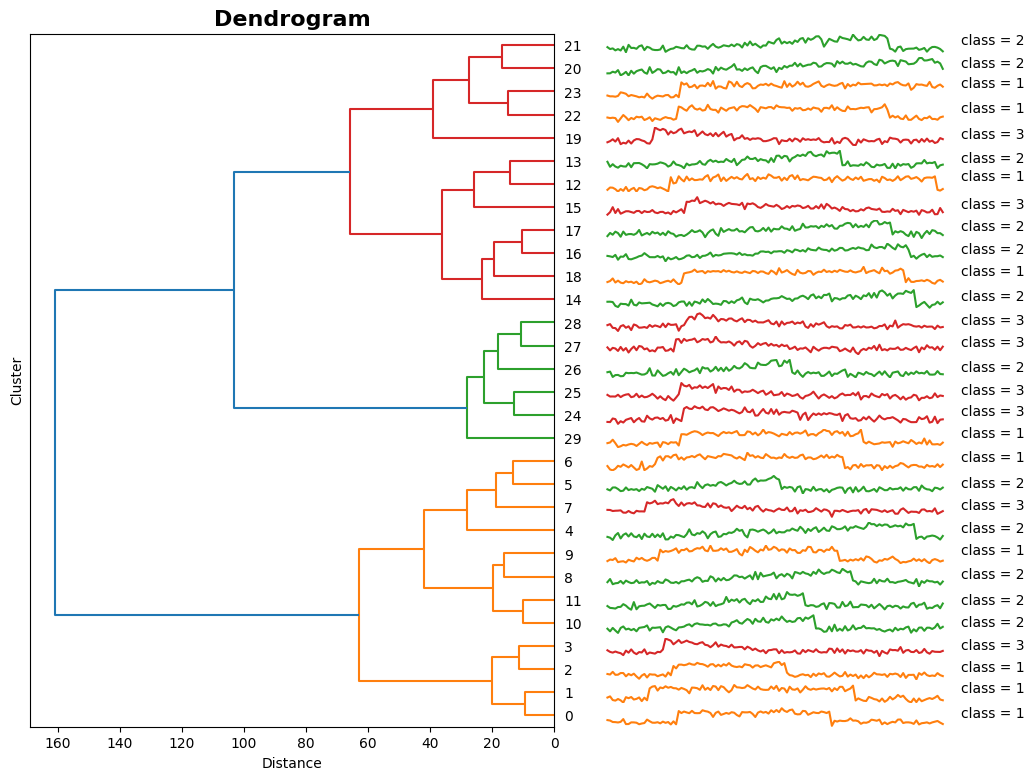

In [21]:
model1.fit(calculate_distance_matrix(ts_set,'euclidean'))
model1.plot_dendrogram(ts_set,labels)

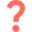
Проанализируйте полученные результаты кластеризации с помощью построенных дендрограмм. Какая на ваш взгляд метрика/мера показала лучший результат и почему? Укажите, в каких случаях более предпочтительно использовать меру DTW, чем метрику Евклида.

*# WRITE YOUR ANSWER*

## **Часть 2.** $Z$-нормализация временных рядов.

### **Задача 5.**
Реализуйте функцию вычисления нормализованного евклидова расстояния между временными рядами `norm_ED_distance()` в модуле *metrics.py* и проверьте правильность своей реализации с помощью функции `ed_distance()` из библиотеки *sktime*, в которую необходимо передать нормализованные временные ряды. Для  нормализации временных рядов используйте функцию `z-normalize()` из *utils.py*.  Для проверки можно использовать синтетические временные ряды из первой части или заново их сгенерировать моделью Random Walk.

*Нормализованная евклидова метрика* между временными рядами $T_1$ и $T_2$ длины $n$ вычисляется следующим образом:

\begin{equation}
	\text{ED}_{norm}\;(T_1, T_2) = \sqrt {2m\left(1-\dfrac{<T_1, T_2> - \; m \; \cdotp \mu_{T_1} \; \cdotp \mu_{T_2}}{m \; \cdotp \sigma_{T_1} \; \cdotp \sigma_{T_2}}\right)},
\end{equation}

где $<T_1, T_2>$ -- скалярное произведение временных рядов, $\mu_{T_1}$ и $\mu_{T_2}$, $\sigma_{T_1}$ и $\sigma_{T_2}$ -- среднее арифметическое и стандартное отклонение временных рядов соответственно.

В свою очередь, *среднее арифметическое* $\mu_T$ и *стандартное отклонение* $\sigma_T$ временного ряда $T$ длины $n$ вычисляются по следующим формулам:

\begin{equation}
	\mu_{T} = \frac{1}{n}\sum\limits_{i=1}^{n} t_{i}, \\[1em]
	\sigma^2_{T} = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} t_i^2-\mu_{T}^2}.
\end{equation}

In [22]:
def test_norm_ed_distance(ts1, ts2):

    sktime_ed_dist = round(euclidean_distance(z_normalize(ts1), z_normalize(ts2)), 5)
    desired_ed_dist = round(norm_ED_distance(ts1, ts2), 5)

    np.testing.assert_equal(sktime_ed_dist, desired_ed_dist, 'Normalized ED distances are not equal')

In [23]:
test_norm_ed_distance(ts1, ts2)

### **Задача 6.**
Далее убедимся, что выполнение $z$-нормализации на этапе предобработки данных имеет важное значение и может повысить точность решаемой задачи.

В данном задании вы продолжите решать задачу иерархической кластеризации. В качестве данных вам предлагается использовать два временных ряда из набора данных BIDMC. Набор BIDMC состоит из записей ЭКГ-сигналов, снятых с 15 пациентов с сердечной недостаточностью тяжелой степени.  

Загрузите два временных ряда и визуализируйте их с помощью функции `plot_ts_set()` из модуля *plots.py*.

In [24]:
url1 = './datasets/part2/chf10.csv'
ts1 = load_ts(url1)

url2 = './datasets/part2/chf11.csv'
ts2 = load_ts(url2)

In [25]:
ts_set = np.concatenate((ts1, ts2), axis=1).T

In [26]:
plot_ts_set(ts_set)

Разделите каждый временной ряд на непересекающиеся подпоследовательности с помощью техники скользящего окна. Для этого используйте функцию `sliding_window()` из модуля *utils.py*, передав в нее временной ряд, заданную длину подпоследовательности и величину шага. В нашем случае, величина шага равна длине подпоследовательности.

In [27]:
m = 125
subs_set1 = sliding_window(ts_set[0], m, m-1)
subs_set2 = sliding_window(ts_set[1], m, m-1)

Сформируйте множество всех подпоследовательностей, извлеченных из двух временных рядов, и массив меток подпоследовательностей в соответствии с их принадлежностью к временному ряду.

In [28]:
subs_set = np.concatenate((subs_set1[0:15], subs_set2[0:15]))
labels = np.array([0]*subs_set1[0:15].shape[0] + [1]*subs_set2[0:15].shape[0])

Добавьте в функцию `calculate_distance_matrix()` поддержку параметра `normalize`, принимающего значения `True` или `False`, для возможности кластеризации нормализованных временных рядов. При этом если матрица расстояний строится для нормализованных временных рядов на основе евклидовой метрики, то должна вызываться функция `norm_ED_distance()`. Для остальных метрик/мер схожести перед нахождением матрицы расстояний временные ряды должны подтвергаться $z$-нормализации с помощью функции `z_normalize()` из модуля *utils.py*.

Далее выполните иерархическую кластеризацию подпоследовательностей двух временных рядов с использованием предварительно построенных матриц расстояний на основе классической и нормализованной евклидовой метрики.

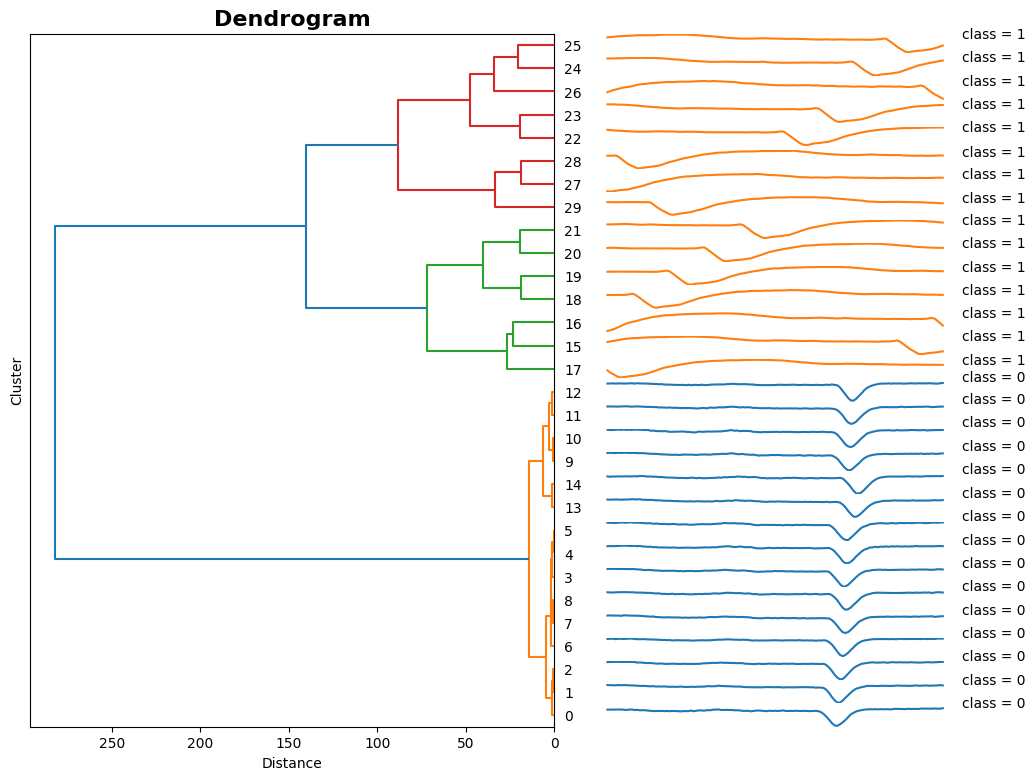

In [29]:
model1.fit(calculate_distance_matrix(subs_set, metric='euclidean', normalize=False))
model1.plot_dendrogram(subs_set,labels)

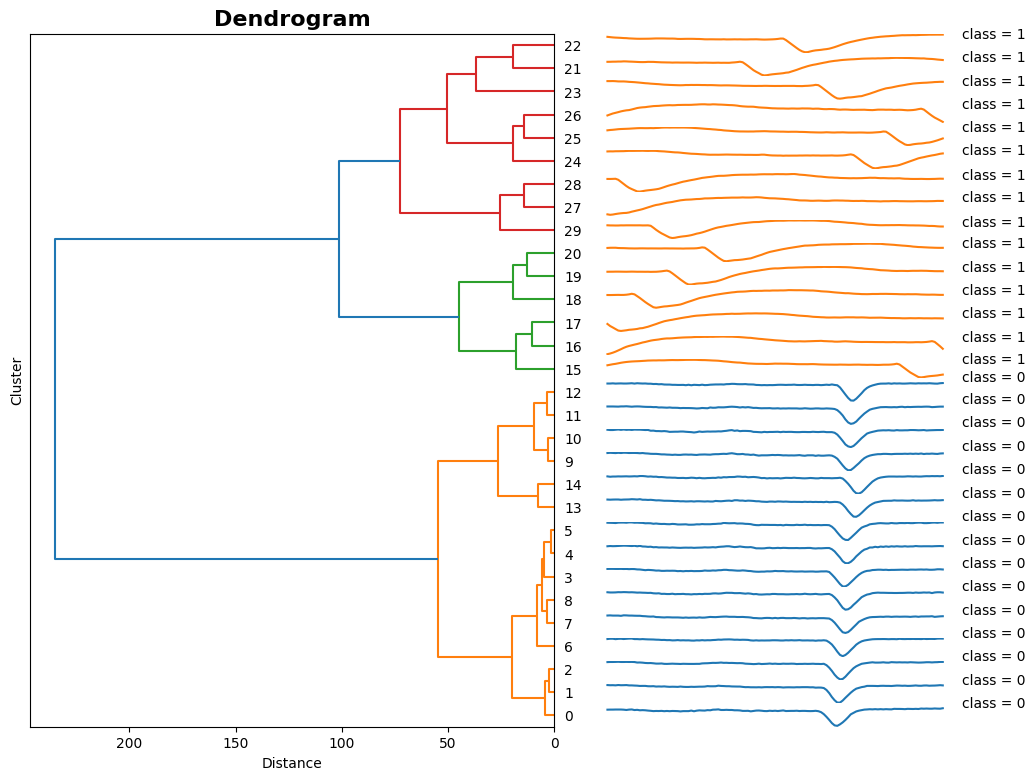

In [30]:
model1.fit(calculate_distance_matrix(subs_set, metric='euclidean', normalize=True))
model1.plot_dendrogram(subs_set,labels)

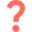
Сравните полученные результаты кластеризации с помощью построенных дендрограмм. Улучшилось ли качество кластеризации, когда временные ряды предварительно подтвергаются $z$-нормализации?

Разницы не наблюдается с и без нормализации рядов

## **Часть 3.** Ускорение вычисления DTW меры техникой ограничения полосы Сако—Чиба. Классификация временных рядов.

### **Задача 7.**
Для ускорения вычисления DTW меры добавьте в функцию `DTW_distance()` возможность ограничения полосы Сако—Чиба, чтобы путь трансформации не отклонялся более чем на $r$ ячеек от диагонали матрицы трансформации. Протестируйте вашу реализацию с помощью функции `dtw_distance()` из библиотеки *sktime* для различных значений параметра $r$.

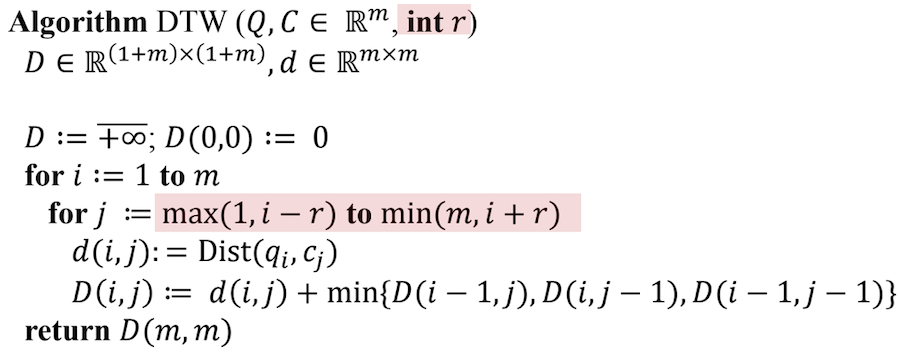

In [31]:
def test_Sako_Chiba_DTW_distance(subs1, subs2, r=0.05):

    sktime_dtw_dist = dtw_distance(subs1, subs2, window=r)
    desired_dtw_distance = DTW_distance(subs1, subs2, r)

    np.testing.assert_equal(sktime_dtw_dist, desired_dtw_distance, f'DTW distances are not equal with r = {r}')

In [32]:
# INSERT YOUR CODE

### **Задача 8.**
Вам необходимо исследовать влияние ширины полосы Сако—Чиба на точность и время работы алгоритма на примере задачи классификации временных рядов. Классификация будет выполняться с помощью алгоритма k-ближайших соседей (KNN). Шаблон класса `TimeSeriesKNN` содержится в модуле *classification.py*, методы которого вам необходимо дописать.


*Метод $k$ ближайших соседей (kNN)* – алгоритм классификации, заключающийся в вычислении сходства между объектами на основе некоторой заданной метрики/меры схожести. Классифицируемый объект относится к тому классу, к которому принадлежит большинство из его $k$ соседей ($k$ ближайших к нему объектов из обучающей выборки).

Для классификации на основе алгоритма kNN необходимо выполнить следующие шаги:

1. Загрузить обучающую и тестовую выборки.

2. Задать параметр алгоритма $k$, где $k$ – количество ближайших соседей, $k \in \mathbb N^*$.

3. Для каждого объекта из тестовой выборки выполнить следующее:

    3.1. Вычислить расстояние до всех объектов из обучающей выборки на основе заданной метрики/меры схожести.

    3.2. Отсортировать в порядке возрастания найденные расстояния.

    3.3. Найти $k$ ближайших соседей, взяв первые $k$ минимальных расстояний из отсортированного массива расстояний.

    3.4. Назначить объекту из тестовой выборки наиболее часто встречающийся класс найденных ранее ближайших соседей.

Загрузите обучающую и тестовую выборки синтетического набора данных CBF, с которым вы уже познакомились при выполнении первой части практической работы. Далее разделите каждую выборку на метки и временные ряды. В первом столбце записаны метки, в остальных – временные ряды.

In [33]:
train_url = './datasets/part3/CBF_TRAIN.txt'
test_url = './datasets/part3/CBF_TEST.txt'

train_data = load_ts(train_url)
test_data = load_ts(test_url)

train_set, train_labels = train_data.iloc[:, 1:], train_data.iloc[:, 0].astype('int32')
test_set, test_labels = test_data.iloc[:, 1:], test_data.iloc[:, 0].astype('int32')

In [34]:
import time

from modules.classification import *

Реализуйте метод `predict()` в классе `TimeSeriesKNN`, который выполняет поиск для каждого элемента из тестовой выборки $k$ ближайших соседей и назначает им тот класс, который является часто встречающимся среди классов ближайших соседей. В качестве параметров в метод `predict()` передается тестовая выборка.

Классифицируйте временные ряды из тестовой выборки датасета CBF и вычислите точность классификации по метрике accuracy с помощью функции `calculate_accurary()` из модуля *classification.py*.

In [35]:
n_neighbors = 5
metric = 'dtw'
r = 0.05
metric_params = {'normalize': True, 'r': r}

# INSERT YOUR CODE

print(f'Точность классификации составила {accuracy}.')

NameError: name 'accuracy' is not defined

### **Задача 9.**
Проведите две серии экспериментов. В первой серии экспериментов исследуйте влияние ширины полосы Сако—Чиба на точность классификации. Во второй серии экспериментов необходимо исследовать влияние ширины полосы Сако—Чиба на время выполнения алгоритма kNN. При этом количество ближайших соседей должно быть зафиксировано.

In [ ]:
accuracy_list = []
times = []

r_list = np.arange(0, 0.9, 0.05)

n_neighbors = 5
metric = 'dtw'

# INSERT YOUR CODE

Постройте график зависимости точности классификации временных рядов от ширины полосы Сако—Чиба.



In [ ]:
x_title = 'Warping Window Size, r'
y_title = 'Accuracy'
plot_title = 'Classification accuracy depending on <br> the warping window size'

plot2d(r_list, accuracy_list, plot_title, x_title, y_title)

Постройте график зависимости времени выполнения алгоритма kNN от ширины полосы Сако—Чиба.

In [ ]:
x_title = 'Warping Window Size, r'
y_title = 'Runtime, s'
plot_title = 'Runtime depending on the warping window size'

plot2d(r_list, times, plot_title, x_title, y_title)

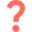
Проанализируйте графики и сделайте выводы.

*# WRITE YOUR ANSWER*